In [1]:
using TaylorSeries, TaylorIntegration
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 20
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

In [2]:
function undrivenHelium!(τ, q, dq)
    tT, Q₁, Q₂, P₁, P₂ = q
    
    t1 = Q₁^2
    t2 = Q₂^2
    t = t1 * t2
    dq[1] = t
    R12 = t1 - t2
    aR12 = abs(R12)
    RRR = aR12^3
    c1 = R12/RRR
    f1 = (1 + 1/aR12)
    f2 = t*c1
   
    dq[2] = 0.25*t2*P₁
    dq[4] = 2*Q₁*(-0.125*P₂^2 + Z  - t2*f1 + f2)
    dq[3] = 0.25*t1*P₂
    dq[5] = 2*Q₂*(-0.125*P₁^2 + Z  - t1*f1 - f2)

#    return [t, q₁, q₂, p₁, p₂] 
    nothing
end
#undrivenHelium(v) = undrivenHelium(0, v)


var1 = set_variables("t q1 q2 p1 p2", order = 1)


function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return [0, Q1, Q2, P1, P2]
end

function regHam(t, Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = abs(Q₁² - Q₂²)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

function errHam(N::Int)
    srand(487293456)
    J = [0 0 0 0 0; 0 0 0 1 0; 0 0 0 0 1; 0 -1 0 0 0; 0 0 -1 0 0 ]
    
    dnorm = zeros(N)
    als = typeof(zeros(5))[]

    for j in 1:N
        al = 10*rand(5)
        meq = similar(al)
        #al = [BigFloat(x) for x in al1]
        alt = al + var1
        ene = J*∇(regHam(alt))
        ene1 = [ene[k].coeffs[1].coeffs[1] for k in 1:5]
        undrivenHelium!(0.0, al, meq)
        push!(als, al)
        meq[1] = 0
        dnorm[j] = norm(meq - ene1) 
    end
    return dnorm, als 
end

errHam (generic function with 1 method)

 17.133324 seconds (313.58 M allocations: 17.554 GiB, 37.24% gc time)



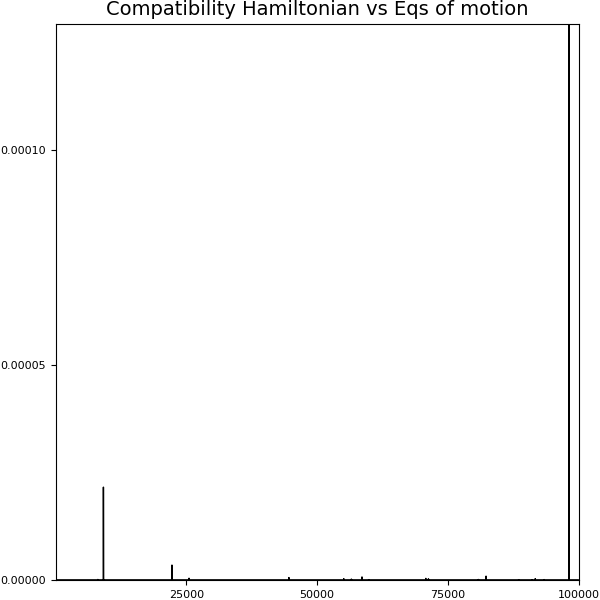

In [3]:
@time dnorm, als= errHam(100_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")

In [4]:
function q2sign(xold, x0, tol)
    if abs(xold[3]) < tol
        sq2o = 0
    else
        sq2o = sign(xold[3])
    end
    
    if abs(x0[3]) < tol
        sq2 = 0
    else
        sq2 = sign(x0[3])
    end
    if abs(xold[5]) < tol
        sp2o = 0
    else
        sp2o = sign(xold[5])
    end
    
    if abs(x0[5]) < tol
        sp2 = 0
    else
        sp2 = sign(x0[5])
    end
    return sq2o, sq2, sp2o, sp2
end
    

q2sign (generic function with 1 method)

In [5]:
###Implementamos nuevo código 

function taylorintegps{T<:Number}(f!, q0::Array{T,1}, t0::T, tmax::T,
    order::Int, abstol::T; maxsteps::Int=5000, tol = 1e-20, tsteps = 1000)

    # Allocation
    const tv = Array{T}(maxsteps+1)
    dof = length(q0)
    const xv = Array{T}(dof, maxsteps+1)
    const vT = zeros(T, order+1)
    vT[2] = one(T)

    # Initialize the vector of Taylor1 expansions
    const x = Array{Taylor1{T}}(dof)
    const dx = Array{Taylor1{T}}(dof)
    const xaux = Array{Taylor1{T}}(dof)
    for i in eachindex(q0)
        @inbounds x[i] = Taylor1( q0[i], order )
    end

    # Initial conditions
    @inbounds tv[1] = t0
    @inbounds xv[:,1] .= q0
    x0 = copy(q0)

    # Integration
    
    nsteps = 1
    #sum1 = q0[3]/maxsteps
    δtn = Inf
    while t0 < tmax
        xold = copy(x0)
        δt = TaylorIntegration.taylorstep!(f!, x, dx, xaux, t0, tmax, x0, order, abstol, vT)
        sq2o, sq2, sp2o, sp2 = q2sign(xold, x0, tol)
        steps1 = 0
        x00 = copy(x0)
        bool1 = false
        
        while sq2o*sq2 == -1 || (sp2o*sp2 == -1 && abs(xold[3]) < tol)
            bool1 = true
            q2T = x[3]
            
            dq2T = derivative(q2T)
            δtn = copy(δt)
            for nc in 1:20
                δtn = δtn - evaluate(q2T, δtn)/evaluate(dq2T, δtn)
            end
            
            evaluate!(x, δtn, x0)
            sq2o, sq2, sp2o, sp2 = q2sign(xold, x0, tol)
            steps1 += 1
            
            if steps1  ≥ tsteps
                break
            end
        end
            
        if bool1 == true
            nsteps += 1
            @inbounds tv[nsteps] = t0 + δtn
            @inbounds xv[:,nsteps] .= x0
            x0 = x00
        end
        if nsteps >= maxsteps
            warn("""
            Maximum number of integration steps reached; exiting.
            """)
            break
        end
        
        for i in eachindex(x0)
            @inbounds x[i][1] = x0[i]
        end
        t0 += δt
        nsteps += 1
        @inbounds tv[nsteps] = t0
        @inbounds xv[:,nsteps] .= x0
        if nsteps >= maxsteps
            warn("""
            Maximum number of integration steps reached; exiting.
            """)
            break
        end
    end

    return view(tv,1:nsteps), view(transpose(xv),1:nsteps,:)
end

taylorintegps (generic function with 1 method)

In [6]:
c1 = condini(2.0, 0.0)

5-element Array{Float64,1}:
 0.0    
 1.41421
 0.0    
 0.0    
 4.0    

In [7]:
t1, x1 = taylorinteg(undrivenHelium!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium!, c1, t0, 15.0, order, abs_tol, maxsteps=100);

  0.292008 seconds (264.90 k allocations: 20.679 MiB, 4.22% gc time)


In [8]:
t2, x2 = taylorintegps(undrivenHelium!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium!, c1, t0, 15.0, order, abs_tol, maxsteps=100);

  0.011700 seconds (191.26 k allocations: 16.169 MiB)


In [9]:
length(t1), length(t2)

(101, 100)

In [10]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam(x1[j,:]))
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam(x2[j,:]))
end


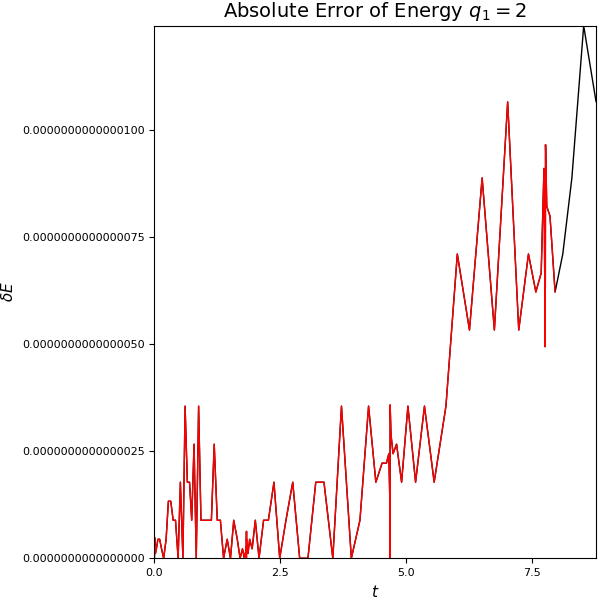

In [11]:
plot(x1[:,1], ene1, title =L"Absolute Error of Energy $q_1=2$")
plot!(x2[:,1], ene2, title =L"Absolute Error of Energy $q_1=2$",color=:red )
xlabel!(L"t")
ylabel!(L"\delta E")
#xlims!(0,5000)


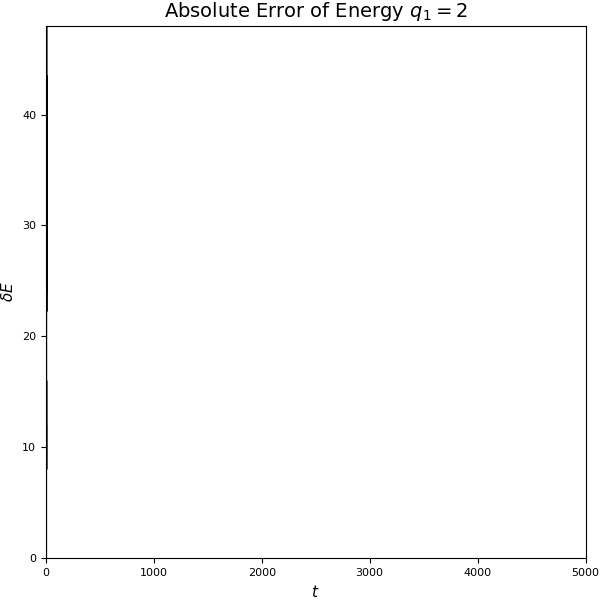

In [12]:
plot(x2[:,1], ene2/eps(), title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")
xlims!(0,5000)

In [13]:
maximum(ene1)

1.2434497875801753e-14

In [14]:
function psundriven(x10::Float64, px10::Float64, tol::Float64 = 1e-20)
    c1 = condini(x10, px10)
    t, x = taylorintegps(undrivenHelium!, c1, t0, 100.0, order, abs_tol)
    ps = zeros(x)
    ts = zeros(t)
    count = 0
    for j in eachindex(ts)
        if abs(x[j,3]) < tol
            count += 1
            ts[count] = t[j]
            ps[count, :] = x[j, :]
        end
    end
    return ps[1:count, :], t, x
end

psundriven (generic function with 2 methods)

In [15]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0)
             end
        ex2 = quote 
            $(nombrexs(j)) = map(ks, $(nombreps(j))[:,2])*0.8/1.8
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  
            Float64[ksv($(nombreps(j))[k,2], $(nombreps(j))[k, 4]) 
                 for k in eachindex($(nombreps(j))[:, 4])]*0.8/1.8
             end
        ex4 = quote 
            $(nombreys(j)) = map(ks, $(nombreq(j))[:,3])*0.8/1.8
             end
        
        ex5 = quote 
            $(nombrevys(j)) =  
                 Float64[ksv($(nombreq(j))[k,3], $(nombreq(j))[k, 5]) 
                 for k in eachindex($(nombret(j)))]*0.8/1.8
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [16]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10);

 55.314099 seconds (637.49 M allocations: 51.777 GiB, 28.73% gc time)


  0.438180 seconds (243.63 k allocations: 11.905 MiB, 2.10% gc time)



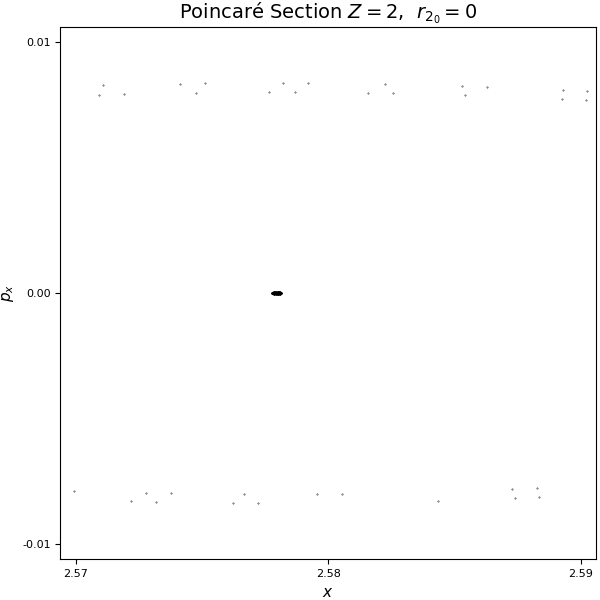

In [17]:
@time plottingps(NM, 2.57, 2.59, -0.01, 0.01)